### Initial Implementation

##### 1. Imports

In [1]:
pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 36.5 MB/s eta 0:00:00


In [2]:
import re
import emoji
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, accuracy_score

##### 2. Load Dataset

In [3]:
# load dataset.
data = load_dataset("shainar/BEAD", "Full_Annotations", split="full")
print(data)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.08k [00:00<?, ?B/s]

Full.csv:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['text', 'dimension', 'biased_words', 'aspect', 'label', 'sentiment', 'toxic', 'identity_mention'],
    num_rows: 3674927
})


In [4]:
# convert to pandas dataframe.
df = data.to_pandas()
print(df.head())

                                                text             dimension  \
0  Where will this leave the kids??? That my frie...  Ageism and sentiment   
1   I had a feeling of impending doom &amp; then ...  Ageism and sentiment   
2                                 I no feel good ..   Ageism and sentiment   
3  Back in Hotlanta for a about a week, then off ...  Ageism and sentiment   
4  Kids toys &amp; stamping stuff cleaned up... N...  Ageism and sentiment   

            biased_words          aspect            label sentiment  toxic  \
0                     []     Transphobia  Slightly Biased  Negative    0.0   
1  ['impending', 'doom']  Climate change    Highly Biased  Negative    1.0   
2                     []    Body-shaming          Neutral  Positive    0.0   
3                     []       Lifestyle  Slightly Biased  Negative    0.0   
4                     []           Hobby          Neutral   Neutral    1.0   

  identity_mention  
0               NO  
1               NO  

In [5]:
# collect 10% of dataset.
df = df.sample(n=300000, random_state=42, replace=True)
print(df.shape)

(300000, 8)


##### 3. Text Pre-processing

In [6]:
# number of empty data items by attribute.
print(df.isnull().sum())

text                    0
dimension               0
biased_words            0
aspect              14474
label                   0
sentiment               0
toxic                   0
identity_mention        0
dtype: int64


In [7]:
# drop blank texts.
df = df.dropna(subset=['text'])

In [8]:
# drop duplicate texts.
df = df.drop_duplicates(subset='text')

In [9]:
# convert text to 'string'.
df['text'] = df['text'].astype(str)

In [10]:
# clean text.
text = df['text']
text = text.apply(lambda x: x.lower())

def edit(text):
	text = emoji.demojize(text).replace(":", "").replace("_", " ")
	text = re.sub(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', '', text)
	text = re.sub(r'https?://\S+|www\.\S+', '', text)
	text = re.sub(r'[^a-z0-9\s.,!?]', '', text)
	text = re.sub(r'\s+', ' ', text).strip()
	return text

text = text.apply(edit)
df['text'] = text

In [11]:
# find range of text lengths.
print("Min text snippet length:", df['text'].astype('string').apply(len).min())
print("Max text snippet length:", df['text'].astype('string').apply(len).max())
print("Avg text snippet length:", df['text'].astype('string').apply(len).mean())

Min text snippet length: 0
Max text snippet length: 32191
Avg text snippet length: 205.01484510885604


In [12]:
# print record with shortest text.
text_len = df['text'].str.len()
ind = text_len.idxmin()
row = df.loc[ind]
print(row)

text                            
dimension               toxicity
biased_words                  []
aspect              Islamophobia
label                    Neutral
sentiment                Neutral
toxic                        0.0
identity_mention              NO
Name: 2511439, dtype: object


In [13]:
# drop texts with length < 5.
min_len = 5
ind_drop = df[df['text'].str.len() < min_len].index
print(f"Dropped {len(ind_drop)} rows.")
df.drop(ind_drop, inplace=True)

Dropped 157 rows.


##### 4. Dataset Characteristics

In [14]:
# number of rows.
print(f"{len(df)} rows.")

287884 rows.


In [15]:
# processed text length range.
print("Min text snippet length:", df['text'].astype('string').apply(len).min())
print("Max text snippet length:", df['text'].astype('string').apply(len).max())
print("Avg text snippet length:", df['text'].astype('string').apply(len).mean())

Min text snippet length: 5
Max text snippet length: 32191
Avg text snippet length: 205.12508163010102


In [16]:
# class distribution of 'label'.
print(df['label'].value_counts())

label
Neutral            147915
Slightly Biased     81253
Highly Biased       58716
Name: count, dtype: int64


In [17]:
# class distribution of 'sentiment'.
print(df['sentiment'].value_counts())

sentiment
Positive    131585
Negative     95936
Neutral      60363
Name: count, dtype: int64


In [18]:
# class distribution of 'toxic'.
print(df['toxic'].value_counts())

toxic
0.0    192162
1.0     95722
Name: count, dtype: int64


##### 5. One-Hot Encoding

In [19]:
# encode categorical columns.
y = pd.DataFrame(data)
target_columns = ['label', 'sentiment', 'toxic']

encoders = {}
for col in target_columns:
  encoder = LabelEncoder()
  df[col] = encoder.fit_transform(df[col])
  encoders[col] = encoder
  print("Mapping:", dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))

Mapping: {'Highly Biased': np.int64(0), 'Neutral': np.int64(1), 'Slightly Biased': np.int64(2)}
Mapping: {'Negative': np.int64(0), 'Neutral': np.int64(1), 'Positive': np.int64(2)}
Mapping: {np.float64(0.0): np.int64(0), np.float64(1.0): np.int64(1)}


In [20]:
# print encoded dataset.
print(df.head())

                                                      text  \
2219110  my bestie changed her username to leeshpaugaso...   
2768307  err, your. must be time for bed. im lucky enou...   
2229084           pam 16 gem yup yup yup bitchy tinkerbell   
3511566  and, gee, sometimes even more than a reasonabl...   
2356330  this german story is bogus. if the song was or...   

                    dimension biased_words             aspect  label  \
2219110  Ageism and sentiment           []        Transphobia      1   
2768307              toxicity           []               None      1   
2229084  Ageism and sentiment   ['bitchy']        Personality      0   
3511566              toxicity           []       Professional      1   
2356330              toxicity           []  Nation stereotype      2   

         sentiment  toxic identity_mention  
2219110          2      0               NO  
2768307          2      1               NO  
2229084          0      1               NO  
3511566       

##### 6. Tokenisation & Padding

In [21]:
# tokenize and pad text for deep learning.
MAX_VOCAB = 10000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])

X = tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(X, maxlen=MAX_LEN, padding='post', truncating='post')

##### 7. Train-Test Split

In [22]:
# target labels.
y = df[['label', 'sentiment', 'toxic']]
print(y)

         label  sentiment  toxic
2219110      1          2      0
2768307      1          2      1
2229084      0          0      1
3511566      1          2      0
2356330      2          0      0
...        ...        ...    ...
522136       1          2      1
2461242      2          0      0
774320       1          1      0
1482739      1          1      0
2184712      1          2      1

[287884 rows x 3 columns]


In [23]:
# split for training, testing anf validation as 80%-10%-10%.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

In [24]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("X_valid:", X_valid.shape)

y_train_label = y_train["label"].to_numpy()
y_train_sentiment = y_train["sentiment"].to_numpy()
y_train_toxic = y_train["toxic"].to_numpy()

y_test_label = y_test["label"].to_numpy()
y_test_sentiment = y_test["sentiment"].to_numpy()
y_test_toxic = y_test["toxic"].to_numpy()

y_valid_label = y_valid["label"].to_numpy()
y_valid_sentiment = y_valid["sentiment"].to_numpy()
y_valid_toxic = y_valid["toxic"].to_numpy()

X_train: (230307, 100)
X_test: (28788, 100)
X_valid: (28789, 100)


##### 8. Model Architecture

In [25]:
embedding_dim = 128

# input layer
input_layer = Input(shape=(X_train.shape[1],))

# hidden layers
x = Embedding(input_dim=MAX_VOCAB, output_dim=embedding_dim, input_length=MAX_LEN)(input_layer)
x = Bidirectional(LSTM(64, return_sequences=False))(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# output layers
output_label = Dense(len(encoders['label'].classes_), activation='softmax', name="output_l")(x)
output_sentiment = Dense(len(encoders['sentiment'].classes_), activation='softmax', name="output_s")(x)
output_toxic = Dense(len(encoders['toxic'].classes_), activation='softmax', name="output_t")(x)

model = Model(inputs=input_layer, outputs=[output_label, output_sentiment, output_toxic])

# model.build(input_shape=(None, MAX_LEN))
model.compile(
    optimizer='adam',
    loss={
        "output_l": "sparse_categorical_crossentropy",
        "output_s": "sparse_categorical_crossentropy",
        "output_t": "sparse_categorical_crossentropy"
    },
    metrics={
        "output_l": "accuracy",
        "output_s": "accuracy",
        "output_t": "accuracy"
    }
  )

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 128)  │  1,280,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     98,816 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_l (Dense)    │ (None, 3)         │        195 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_s (Dense)    │ (None, 3)         │        195 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_t (Dense)    │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,387,848 (5.29 MB)

 Trainable params: 1,387,720 (5.29 MB)

 Non-trainable params: 128 (512.00 B)

##### 9. Model Training

In [26]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    X_train,
    {
        "output_l": y_train_label,
        "output_s": y_train_sentiment,
        "output_t": y_train_toxic
    },
    validation_data=(
        X_valid,
        {
            "output_l": y_valid_label,
            "output_s": y_valid_sentiment,
            "output_t": y_valid_toxic
        }
    ),
    epochs=10,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/10
7198/7198 ━━━━━━━━━━━━━━━━━━━━ 127s 17ms/step - loss: 1.9687 - output_l_accuracy: 0.6698 - output_l_loss: 0.7301 - output_s_accuracy: 0.7112 - output_s_loss: 0.6702 - output_t_accuracy: 0.7118 - output_t_loss: 0.5684 - val_loss: 1.2524 - val_output_l_accuracy: 0.8145 - val_output_l_loss: 0.4699 - val_output_s_accuracy: 0.8832 - val_output_s_loss: 0.3573 - val_output_t_accuracy: 0.8100 - val_output_t_loss: 0.4253
Epoch 2/10
7198/7198 ━━━━━━━━━━━━━━━━━━━━ 137s 17ms/step - loss: 1.3020 - output_l_accuracy: 0.8116 - output_l_loss: 0.4898 - output_s_accuracy: 0.8783 - output_s_loss: 0.3811 - output_t_accuracy: 0.8098 - output_t_loss: 0.4311 - val_loss: 1.1684 - val_output_l_accuracy: 0.8297 - val_output_l_loss: 0.4390 - val_output_s_accuracy: 0.8913 - val_output_s_loss: 0.3325 - val_output_t_accuracy: 0.8241 - val_output_t_loss: 0.3970
Epoch 3/10
7198/7198 ━━━━━━━━━━━━━━━━━━━━ 147s 17ms/step - loss: 1.1920 - output_l_accuracy: 0.8331 - output_l_loss: 0.4469 - output_s_accuracy: 0

##### 10. Model Evaluation

In [27]:
# evaluate model.
y_pred_probs = model.predict(X_test)

y_pred_label = np.argmax(y_pred_probs[0], axis=1)
y_pred_sentiment = np.argmax(y_pred_probs[1], axis=1)
y_pred_toxic = np.argmax(y_pred_probs[2], axis=1)

print("====================== Bias Task ======================")
print("Accuracy:", accuracy_score(y_test_label, y_pred_label))
print(classification_report(y_test_label, y_pred_label, target_names=encoders["label"].classes_))

print("\n====================== Sentiment Task ======================")
print("Accuracy:", accuracy_score(y_test_sentiment, y_pred_sentiment))
print(classification_report(y_test_sentiment, y_pred_sentiment, target_names=encoders["sentiment"].classes_))

print("\n====================== Toxic Task ======================")
print("Accuracy:", accuracy_score(y_test_toxic, y_pred_toxic))
print(classification_report(y_test_toxic, y_pred_toxic, target_names=[str(cls) for cls in encoders["toxic"].classes_]))

900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
====================== Bias Task ======================
Accuracy: 0.8323954425455051
                 precision    recall  f1-score   support

  Highly Biased       0.80      0.77      0.79      5872
        Neutral       0.90      0.92      0.91     14791
Slightly Biased       0.73      0.71      0.72      8125

       accuracy                           0.83     28788
      macro avg       0.81      0.80      0.81     28788
   weighted avg       0.83      0.83      0.83     28788


====================== Sentiment Task ======================
Accuracy: 0.889606780603029
              precision    recall  f1-score   support

    Negative       0.86      0.87      0.87      9593
     Neutral       0.94      0.85      0.89      6037
    Positive       0.89      0.92      0.90     13158

    accuracy                           0.89     28788
   macro avg       0.90      0.88      0.89     28788
weighted avg       0.89      0.89      0.89     28788




##### 12. Visualization


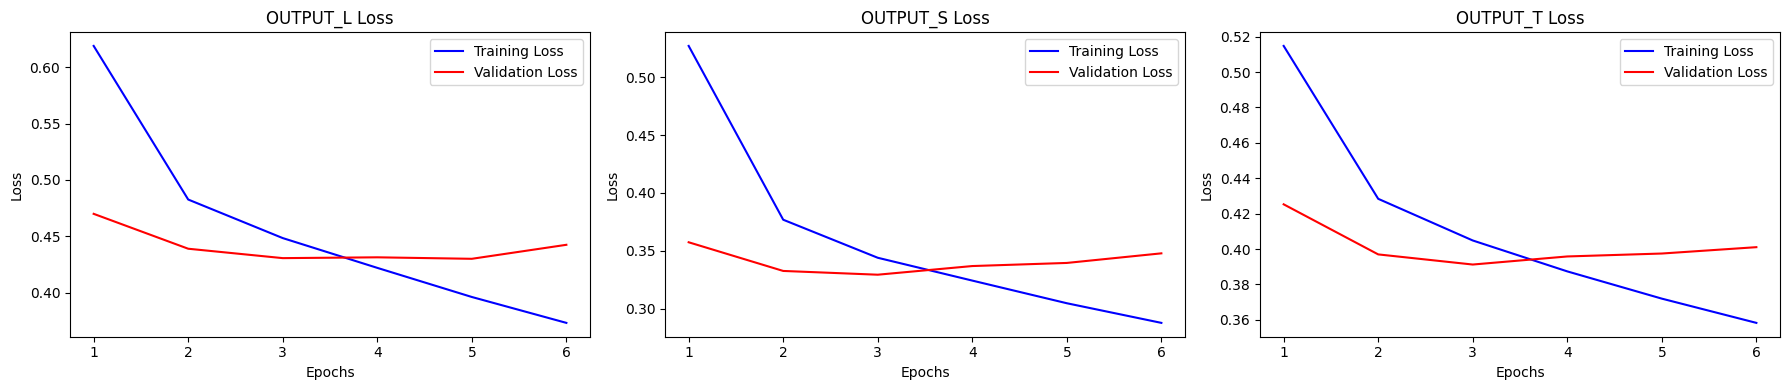

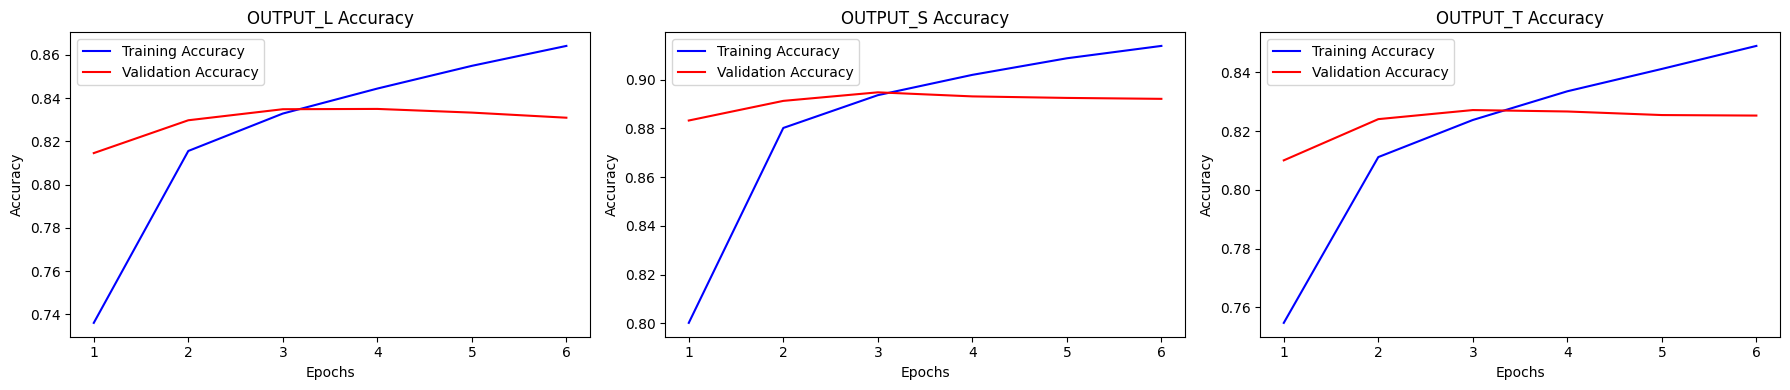

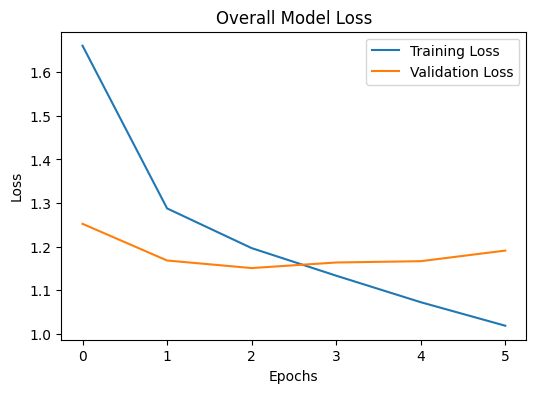

In [28]:
def plot_output(history, outputs, metric="accuracy"):
    epochs = range(1, len(history.history[f"{outputs[0]}_loss"]) + 1)

    # accuracy plot
    fig, axes = plt.subplots(1, len(outputs), figsize=(18, 4))
    for i, output in enumerate(outputs):
        train_loss = history.history[f"{output}_loss"]
        val_loss = history.history[f"val_{output}_loss"]

        axes[i].plot(epochs, train_loss, "b", label="Training Loss")
        axes[i].plot(epochs, val_loss, "r", label="Validation Loss")
        axes[i].set_title(f"{output.upper()} Loss")
        axes[i].set_xlabel("Epochs")
        axes[i].set_ylabel("Loss")
        axes[i].legend()
    plt.tight_layout()
    plt.show()

    # loss plot
    fig, axes = plt.subplots(1, len(outputs), figsize=(18, 4))
    for i, output in enumerate(outputs):
        train_metric = history.history[f"{output}_{metric}"]
        val_metric = history.history[f"val_{output}_{metric}"]

        axes[i].plot(epochs, train_metric, "b", label=f"Training {metric.title()}")
        axes[i].plot(epochs, val_metric, "r", label=f"Validation {metric.title()}")
        axes[i].set_title(f"{output.upper()} {metric.title()}")
        axes[i].set_xlabel("Epochs")
        axes[i].set_ylabel(metric.title())
        axes[i].legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Overall Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

outputs = ["output_l", "output_s", "output_t"]
plot_output(history, outputs, metric="accuracy")
